In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from sklearn.model_selection import train_test_split
K.set_image_dim_ordering('th')
%matplotlib 

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Using matplotlib backend: nbAgg


In [168]:
datagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        rescale =1/255.,
        #zoom_range=.5,
        data_format="channels_last")
gt_generator2 = datagen.flow_from_directory(
        directory="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/depth",
        shuffle =False,
        **flow_from_directory_params_grey
)

Found 3998 images belonging to 1 classes.


In [301]:
img_height, img_width = 480,640
from keras.preprocessing import image
from itertools import izip

batch_size = 2
def hot_vectorize(x):
    zero_mask = x==0
    non_zero_mask = x!=0
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x

def combine_data_generators(depth,normal,rgb,mask):
    while True:
            d = depth.next()
            n = normal.next()
            r = rgb.next()
            m = mask.next()
            yield (np.concatenate((d,n,r),3),m)
            
labeldatagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        #zoom_range=.5,plt.figure()
        preprocessing_function = hot_vectorize,
        data_format="channels_last")

datagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        rescale =1/255.,
        #zoom_range=.5,
        data_format="channels_last")

flow_from_directory_params_grey = {'target_size': (img_height,img_width),
                                  'color_mode': 'grayscale',
                                  'class_mode': None,
                                  'batch_size': batch_size}

flow_from_directory_params_color = {'target_size': (img_height,img_width),
                                  'color_mode': 'rgb',
                                  'class_mode': None,
                                  'batch_size': batch_size}


mask_generator1 = labeldatagen.flow_from_directory(
        directory="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/depth",
        shuffle = False,
        **flow_from_directory_params_grey
    )
rgb_generator1 = datagen.flow_from_directory(
        directory="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/rgb",
        shuffle = False,
        **flow_from_directory_params_color
    )
normal_generator1 = datagen.flow_from_directory(
        directory="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/normal",
        shuffle = False,
        **flow_from_directory_params_color
    )
gt_generator1 = datagen.flow_from_directory(
        directory="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/gtdepth",
        shuffle =False,
        **flow_from_directory_params_grey
    )
train_generator1 = combine_data_generators(gt_generator1,normal_generator1,rgb_generator1,mask_generator1)

Found 717 images belonging to 1 classes.
Found 717 images belonging to 1 classes.
Found 717 images belonging to 1 classes.
Found 717 images belonging to 1 classes.


In [12]:
def hot_vectorize(x):
    zero_mask = x==0
    non_zero_mask = x!=0
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x

def stack_frames(gtdepth,normal,rgb,img_height,img_width):
	stack = np.zeros((1,img_height,img_width,7)) # other prepping?? /255
	stack[0,:,:,4:] = rgb
	stack[0,:,:,1:4] = normal
	stack[0,:,:,0] = gtdepth
	return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def normalize(x):
    return x/255.

In [13]:

def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=2,path="/media/drc/DATA/chris_labelfusion/CORL2017/test_data/",dir_name = "test/",filter_files = None,func=None):

	rgb_path = path+"rgb/"+dir_name
	depth_path = path+"depth/"+ dir_name
	gtdepth_path = path+"gtdepth/" + dir_name
	normal_path = path+"normal/" + dir_name

	rgb = np.sort(os.listdir(rgb_path))
	normal = np.sort(os.listdir(normal_path))
	depth = np.sort(os.listdir(depth_path))
	gtdepth = np.sort(os.listdir(gtdepth_path))

	if filter_files:
		rgb = np.sort(filter(lambda x: filter_files in x, rgb))
		normal = np.sort(filter(lambda x: filter_files in x, normal))
		depth = np.sort(filter(lambda x: filter_files in x, depth))
		gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

	i = 0
	while True:
		rgb_img = grab_frame(rgb,i,rgb_path,func)
		normal_img = grab_frame(normal,i,normal_path,func)
		gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,func)
		depth_img = grab_frame(depth,i,depth_path,func)
		stack = stack_frames(gtdepth_img,normal_img,rgb_img,img_height,img_width)
		yield stack

In [18]:
gen.next()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


array([[[[0.        , 0.        , 0.        , ..., 0.41176471,
          0.45490196, 0.42352941],
         [0.        , 0.        , 0.        , ..., 0.47843137,
          0.51372549, 0.43137255],
         [0.        , 0.        , 0.        , ..., 0.43529412,
          0.44705882, 0.2627451 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.54117647,
          0.58823529, 0.53333333],
         [0.        , 0.        , 0.        , ..., 0.54509804,
          0.6       , 0.54901961],
         [0.        , 0.        , 0.        , ..., 0.56470588,
          0.61960784, 0.56862745]],

        [[0.        , 0.        , 0.        , ..., 0.49019608,
          0.54901961, 0.52941176],
         [0.        , 0.        , 0.        , ..., 0.47843137,
          0.52941176, 0.4627451 ],
         [0.        , 0.        , 0.        , ..., 0.4745098 ,
          0.50196078, 0.3372549 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.55294118,
          0.6       , 0.5

In [14]:
gen  = generate_data_custom(func=normalize)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


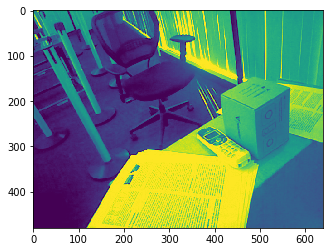

In [17]:
%matplotlib inline
plt.imshow(np.reshape(gen.next()[0,:,:,4],(480,640)))

In [169]:
a = gt_generator2.next()

<IPython.core.display.Javascript object>


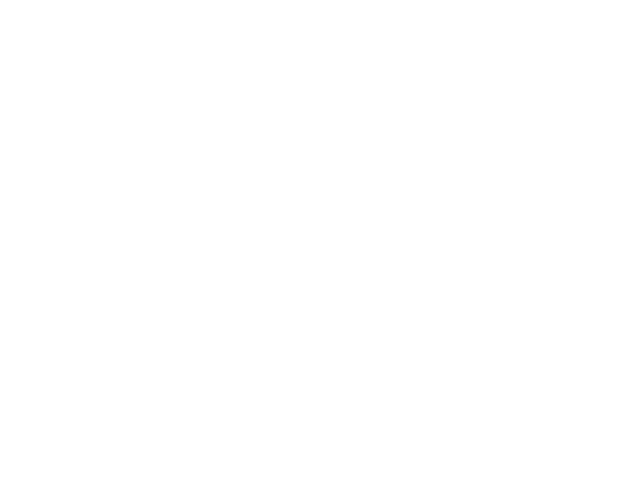

In [170]:
%matplotlib nbagg
plt.imshow(np.reshape(a[0],(480,640)))

In [193]:
img_height, img_width = 480,640
from keras.preprocessing import image
from itertools import izip

batch_size = 2
def hot_vectorize(x):
    zero_mask = x==0
    non_zero_mask = x!=0
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x

def combine_data_generators(depth,normal,rgb,mask):
    while True:
            d = depth.next()
            n = normal.next()
            r = rgb.next()
            m = mask.next()
            yield (np.concatenate((d,n,r),3),m)
            
labeldatagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        #zoom_range=.5,plt.figure()
        preprocessing_function = hot_vectorize,
        data_format="channels_last")

datagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        rescale =1/255.,
        #zoom_range=.5,
        data_format="channels_last")

flow_from_directory_params_grey = {'target_size': (img_height,img_width),
                                  'color_mode': 'grayscale',
                                  'class_mode': None,
                                  'batch_size': batch_size}

flow_from_directory_params_color = {'target_size': (img_height,img_width),
                                  'color_mode': 'rgb',
                                  'class_mode': None,
                                  'batch_size': batch_size}


mask_generator = labeldatagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/depth",
        shuffle = False,
        **flow_from_directory_params_grey
    )
rgb_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/rgb",
        shuffle = False,
        **flow_from_directory_params_color
    )
normal_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/normal",
        shuffle = False,
        **flow_from_directory_params_color
    )
gt_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/gtdepth",
        shuffle =False,
        **flow_from_directory_params_grey
    )

Found 117661 images belonging to 1 classes.
Found 117661 images belonging to 1 classes.
Found 117521 images belonging to 1 classes.
Found 117521 images belonging to 1 classes.


In [194]:
train_generator = combine_data_generators(gt_generator,normal_generator,rgb_generator,mask_generator)

In [195]:
inputs = Input((img_height, img_width,7))

In [196]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(7, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(7, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(drop4)

conv5 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool4)
conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(112, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge6)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv6)

up7 = Conv2D(56, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(28, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(14, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 7)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 7)  448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 7)  448         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 7)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The `m

In [197]:
model.load_weights("RGBDCNN/unet.hdf5")

In [7]:
model_checkpoint = ModelCheckpoint('unet1.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model.fit_generator(train_generator, nb_epoch=100,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=100, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4217 - acc: 0.8205
Epoch 00001: loss improved from inf to 0.42073, saving model to unet.hdf5
100/100 [==============================] - 26s 258ms/step - loss: 0.4207 - acc: 0.8207
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.8599
Epoch 00002: loss improved from 0.42073 to 0.33372, saving model to unet.hdf5
100/100 [==============================] - 22s 217ms/step - loss: 0.3337 - acc: 0.8607
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3079 - acc: 0.9211
Epoch 00003: loss improved from 0.33372 to 0.30753, saving model to unet.hdf5
100/100 [==============================] - 25s 254ms/step - loss: 0.3075 - acc: 0.9213
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2795 - acc: 0.9259
Epoch 00004: loss improved from 0.30753 to 0.27906, saving model to unet.hdf5
100/100 [==============================] - 25s 251ms/step - los

Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1796 - acc: 0.9543
Epoch 00034: loss did not improve
100/100 [==============================] - 27s 274ms/step - loss: 0.1793 - acc: 0.9544
Epoch 35/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1805 - acc: 0.9538
Epoch 00035: loss did not improve
100/100 [==============================] - 27s 273ms/step - loss: 0.1804 - acc: 0.9538
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1777 - acc: 0.9545
Epoch 00036: loss improved from 0.17758 to 0.17743, saving model to unet.hdf5
100/100 [==============================] - 27s 273ms/step - loss: 0.1774 - acc: 0.9546
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.9545
Epoch 00037: loss improved from 0.17743 to 0.17607, saving model to unet.hdf5
100/100 [==============================] - 28s 278ms/step - loss: 0.1761 - acc: 0.9546
Epoch 38/100
 99/100 [============================>.] - 

In [318]:
np.shape(test[0]imgs_mask_test[0])

(2, 480, 640, 7)

In [313]:
test = train_generator1.next()
X_Test = test[0][0:1]
Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)

In [353]:
X_Test1 = np.copy(X_Test)
#X_Test1[:,:,:,0]=0
X_Test1[:,:,:,1:4]=0
X_Test1[:,:,:,4:]=0
imgs_mask_test = model.predict_on_batch(X_Test1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


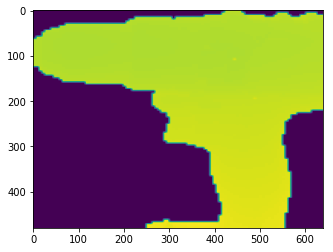

In [115]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/gan_data/sim/train/"
img = path+ np.random.choice(os.listdir(path))
test =  misc.imresize(misc.imread(img),(480,640))
plt.imshow(test)

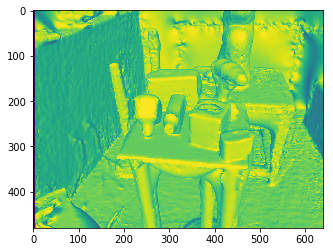

In [128]:
img = np.reshape(X_Test1[0,:,:,3],(img_height,img_width))
plt.imshow(img)

In [201]:
def prob_map_to_mask(prob_map,width=2):
    prob_map = np.copy(prob_map)
    h,w = np.shape(prob_map)
    zeros = np.argwhere(prob_map>0)
    for index in zeros:
        i = index[0]
        j = index[1]
        if i-width>0 and i+width<h and j-width>0 and j+width<w:
            if prob_map[i-width,j]<.1 or prob_map[i,j-width]<.1 or prob_map[i+width,j]<.1 or prob_map[i,j+width]<.1:
                prob_map[i,j] = np.random.binomial(1,prob_map[i,j])
            else: prob_map[i,j] = 1
    return prob_map

In [202]:
def prob_map_to_mask(prob_map,dev=.1):# noisify and sample from prob map #threshold for probability sample otherwise detierministic as well as location based sharp cutffs
    def sample(i):
        return np.random.binomial(1,i)
    func = np.vectorize(sample)
    return func(prob_map)    

In [203]:
def prob_map_to_mask(prob_map,dev=.1):
    prob_map = np.copy(prob_map)
    prob_map[prob_map>.5] = 1
    return prob_map

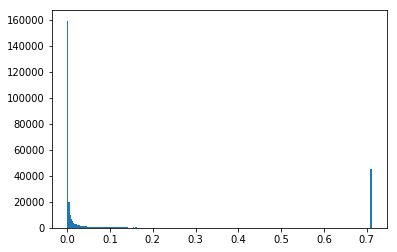

In [222]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [200]:
plt.imshow(prob_map_to_mask(img))
clb = plt.colorbar()
clb.ax.set_title('Depth mask')

NameError: name 'prob_map_to_mask' is not defined

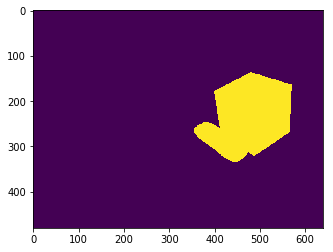

In [ ]:
%matplotlib inline
img = np.reshape(X_Test1[:,:,:,0],(img_height,img_width))
plt.imshow(img)

In [ ]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

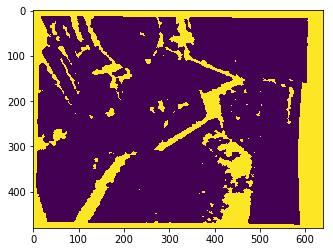

In [335]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img1)

In [169]:
train = train_generator.next()
X = train[0]
Y = train[1]
inputs = Input((1,img_height, img_width))

In [171]:
conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)

conv3 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
#drop4 = Dropout(0.5)(conv4)

conv5 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)

conv6 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
#drop5 = Dropout(0.5)(conv5)


model1 = Model(input = inputs, output = conv6)
print model1.summary()
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 480, 640)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 480, 640)      832       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 480, 640)      51264     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 480, 640)      51232     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 480, 640)      4624      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 480, 640)       37        
Total para

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [217]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model1.fit_generator(train_generator, steps_per_epoch=100,nb_epoch=10, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...
Epoch 1/10
  1/100 [..............................] - ETA: 13s - loss: 0.3969 - acc: 0.8304

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


 99/100 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8321
Epoch 00001: loss improved from inf to 0.38894, saving model to unet.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.3889 - acc: 0.8322
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3845 - acc: 0.8345
Epoch 00002: loss improved from 0.38894 to 0.38439, saving model to unet.hdf5
100/100 [==============================] - 10s 97ms/step - loss: 0.3844 - acc: 0.8345
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8282
Epoch 00003: loss did not improve
100/100 [==============================] - 10s 97ms/step - loss: 0.3851 - acc: 0.8281
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8301
Epoch 00004: loss improved from 0.38439 to 0.37768, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3777 - acc: 0.8301
Epoch 5/10
 99/100 [==================

In [229]:
test = train_generator.next()
X_Test = test[0][0:50]
Y_Test = test[1][0:50]

In [232]:
np.shape(X_Test),np.shape(imgs_mask_test)

((1, 1, 480, 640), (1, 1, 480, 640))

In [236]:
imgs_mask_test = model1.predict_on_batch(X_Test)

In [284]:
%matplotlib inline

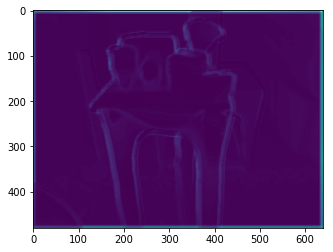

In [242]:
index = np.random.randint(10)
img = np.reshape(imgs_mask_test,(img_height,img_width))
plt.imshow(img)

In [34]:
count = 0

In [177]:
from PIL import Image
im = Image.open(img)
plt.imshow(im)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


<IPython.core.display.Javascript object>


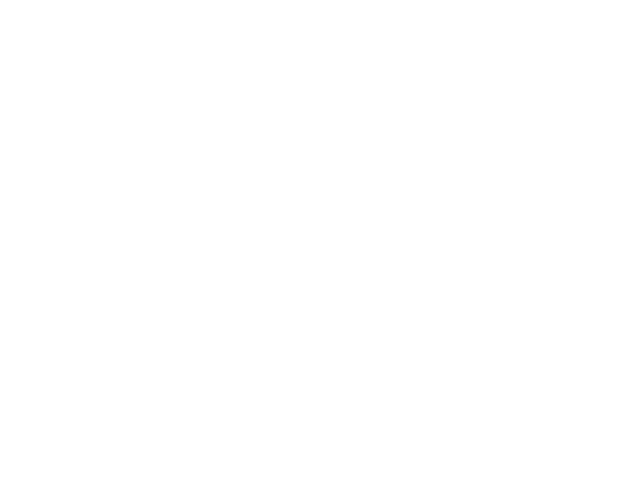

In [187]:
%matplotlib nbagg
path = "/media/drc/DATA/CNN/gtdepth/gtdepth/0000000007_2017-05-25-19_depth_ground_truth.png"
#path = "/media/drc/DATA/CNN/gtdepth/gtdepth/"
#img = path+ os.listdir(path)[count]
test =  misc.imresize(misc.imread(path),(480,640))
plt.imshow(test)
count+=1

In [282]:
%%timeit
perlin(x,y,seed=2)

100 loops, best of 3: 4.57 ms per loop


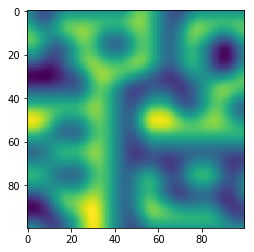

In [269]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin) # FIX3: I thought I had to invert x and y here but it was a mistake
plt.figure()
plt.imshow(perlin(x,y,seed=2),origin='upper')

In [270]:
img

array([[0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       ...,
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028]], dtype=float32)

In [281]:
%%timeit
edges1 = filter.canny(rg)

10 loops, best of 3: 79.8 ms per loop


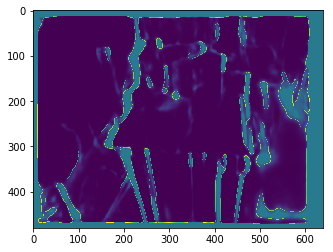

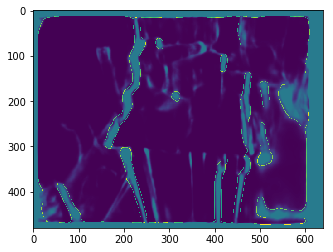

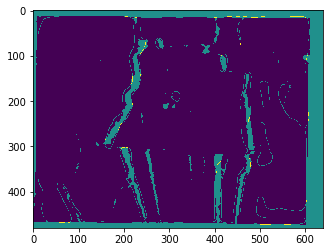

In [279]:
from scipy import ndimage as ndi
from skimage import filter
from skimage import color
from skimage import io
rg = ndi.gaussian_filter(img,4)
edges1 = filter.canny(rg)
edges2 = filter.canny(rg,sigma =6)
plt.figure()
plt.imshow(edges1+img)
plt.figure()
plt.imshow(edges2+img)
plt.figure()
plt.imshow(edges2+img1)

In [293]:
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)

In [294]:
%%timeit
gaussian_filter(img, 1, mode='constant')

100 loops, best of 3: 4.56 ms per loop


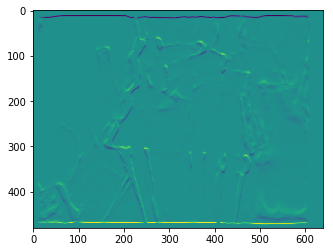

In [299]:
img_smooth = gaussian_filter(img, .5, mode='constant')
plt.imshow(np.gradient(img_smooth)[0])

In [ ]:
"""
canny.py - Canny Edge detector

Reference: Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
    Pattern Analysis and Machine Intelligence, 8:679-714, 1986

Originally part of CellProfiler, code licensed under both GPL and BSD licenses.
Website: http://www.cellprofiler.org
Copyright (c) 2003-2009 Massachusetts Institute of Technology
Copyright (c) 2009-2011 Broad Institute
All rights reserved.
Original author: Lee Kamentsky
"""

import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)
from .. import dtype_limits
from .._shared.utils import assert_nD


def smooth_with_function_and_mask(image, function, mask):
    """Smooth an image with a linear function, ignoring masked pixels

    Parameters
    ----------
    image : array
        Image you want to smooth.
    function : callable
        A function that does image smoothing.
    mask : array
        Mask with 1's for significant pixels, 0's for masked pixels.

    Notes
    ------
    This function calculates the fractional contribution of masked pixels
    by applying the function to the mask (which gets you the fraction of
    the pixel data that's due to significant points). We then mask the image
    and apply the function. The resulting values will be lower by the
    bleed-over fraction, so you can recalibrate by dividing by the function
    on the mask to recover the effect of smoothing from just the significant
    pixels.
    """
    bleed_over = function(mask.astype(float))
    masked_image = np.zeros(image.shape, image.dtype)
    masked_image[mask] = image[mask]
    smoothed_image = function(masked_image)
    output_image = smoothed_image / (bleed_over + np.finfo(float).eps)
    return output_image


def canny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    """Edge filter an image using the Canny algorithm.

    Parameters
    -----------
    image : 2D array
        Greyscale input image to detect edges on; can be of any dtype.
    sigma : float
        Standard deviation of the Gaussian filter.
    low_threshold : float
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude values. If True
        then the thresholds must be in the range [0, 1].

    Returns
    -------
    output : 2D array (image)
        The binary edge map.

    See also
    --------
    skimage.sobel

    Notes
    -----
    The steps of the algorithm are as follows:

    * Smooth the image using a Gaussian with ``sigma`` width.

    * Apply the horizontal and vertical Sobel operators to get the gradients
      within the image. The edge strength is the norm of the gradient.

    * Thin potential edges to 1-pixel wide curves. First, find the normal
      to the edge at each point. This is done by looking at the
      signs and the relative magnitude of the X-Sobel and Y-Sobel
      to sort the points into 4 categories: horizontal, vertical,
      diagonal and antidiagonal. Then look in the normal and reverse
      directions to see if the values in either of those directions are
      greater than the point in question. Use interpolation to get a mix of
      points instead of picking the one that's the closest to the normal.

    * Perform a hysteresis thresholding: first label all points above the
      high threshold as edges. Then recursively label any point above the
      low threshold that is 8-connected to a labeled point as an edge.

    References
    -----------
    .. [1] Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
           Pattern Analysis and Machine Intelligence, 8:679-714, 1986
    .. [2] William Green's Canny tutorial
           http://dasl.mem.drexel.edu/alumni/bGreen/www.pages.drexel.edu/_weg22/can_tut.html

    Examples
    --------
    >>> from skimage import feature
    >>> # Generate noisy image of a square
    >>> im = np.zeros((256, 256))
    >>> im[64:-64, 64:-64] = 1
    >>> im += 0.2 * np.random.rand(*im.shape)
    >>> # First trial with the Canny filter, with the default smoothing
    >>> edges1 = feature.canny(im)
    >>> # Increase the smoothing for better results
    >>> edges2 = feature.canny(im, sigma=3)
    """

    #
    # The steps involved:
    #
    # * Smooth using the Gaussian with sigma above.
    #
    # * Apply the horizontal and vertical Sobel operators to get the gradients
    #   within the image. The edge strength is the sum of the magnitudes
    #   of the gradients in each direction.
    #
    # * Find the normal to the edge at each point using the arctangent of the
    #   ratio of the Y sobel over the X sobel - pragmatically, we can
    #   look at the signs of X and Y and the relative magnitude of X vs Y
    #   to sort the points into 4 categories: horizontal, vertical,
    #   diagonal and antidiagonal.
    #
    # * Look in the normal and reverse directions to see if the values
    #   in either of those directions are greater than the point in question.
    #   Use interpolation to get a mix of points instead of picking the one
    #   that's the closest to the normal.
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #
    assert_nD(image, 2)

    if low_threshold is None:
        low_threshold = 0.1 * dtype_limits(image, clip_negative=False)[1]

    if high_threshold is None:
        high_threshold = 0.2 * dtype_limits(image, clip_negative=False)[1]

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return gaussian_filter(x, sigma, mode='constant')

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)
    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask